# Week 2 progress
Focuses this week
- Improving noise removal
- Using spectral lines to convert measured intensities to photon energies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from histograms import fit_pedestal, make_histogram, subtract_pedestal
from file_utils import load_image
from matplotlib.colors import LogNorm
from hit_detection import get_hot_pixels

# Load an image
img = load_image("data/images/image8.npy")
bin_centres, hist_data = make_histogram(img, 100)

# Fit and subtract the pedestal
pedestal_params, _ = fit_pedestal(bin_centres, hist_data)
pedestal_subtracted = subtract_pedestal(img, pedestal_params)

# Get hot pixels
hot_pixels = get_hot_pixels(img, 5)

# A better way of removing noise

The CCD manual and other literature suggests that the dark current can vary from pixel to pixel. As such, it may make sense to try and calculate a noise value for each pixel individually.

To do this, I:

- Get baseline values $\mu_0$ and $\sigma_0$ for the mean and standard deviation values for every pixel over the 20 images.
- Use these to estimate the noise. Just using $\mu_0$ is naive, as some of this data will be due to photon hits, which are not noise.
    - Instead, I re-calculate the mean using only pixels that are not expected to be "hot" - ie are less than $\mu_0+n\sigma_0$ where $n$ is a tuneable parameter
- I then get a 2D bias array, which I subtract from the image.

In [3]:
all_images = np.array([load_image(f"data/images/image{i}.npy") for i in range(20)])
all_images.shape

(20, 2048, 2048)

Text(0.5, 1.0, 'Bias')

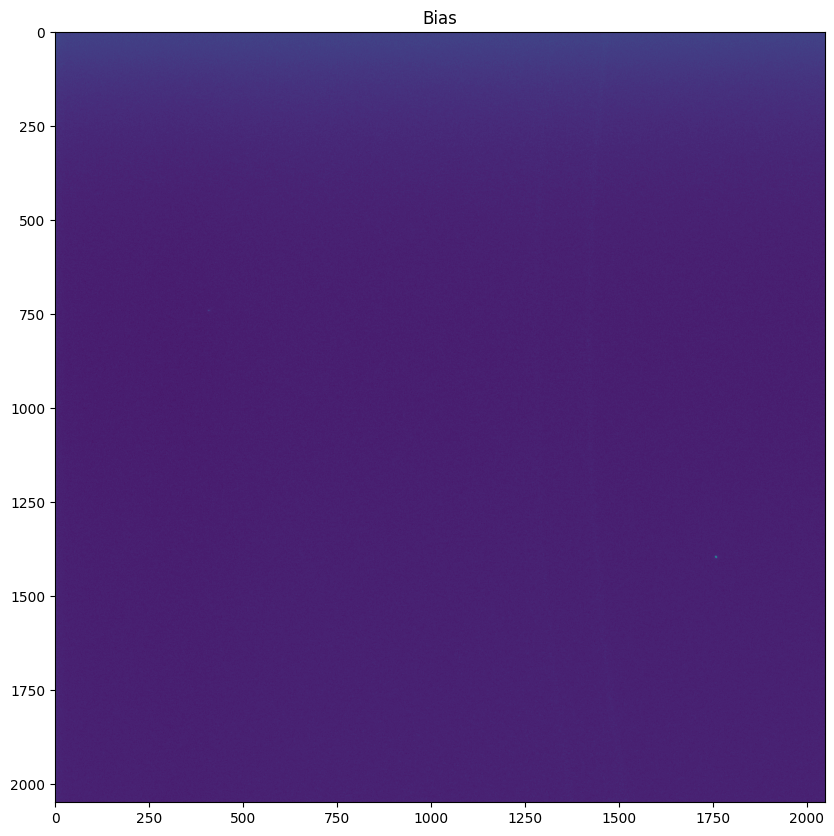

In [4]:
pixel_means = np.mean(all_images, axis=0)
pixel_stds = np.std(all_images, axis=0)
pixel_medians = np.median(all_images, axis=0)

# we want the mean of the noise, so only consider pixels that are not hot
bias = np.zeros(img.shape)
n_avg = np.zeros(img.shape)
n=2

for raw_img in all_images:

    bias += np.where(raw_img < pixel_medians + n*pixel_stds, raw_img, 0)
    n_avg += (raw_img < pixel_medians + n*pixel_stds).astype(int)

bias /= n_avg

plt.figure(figsize=(10,10))
plt.imshow(bias)
plt.title("Bias")

Text(0.5, 1.0, 'Original')

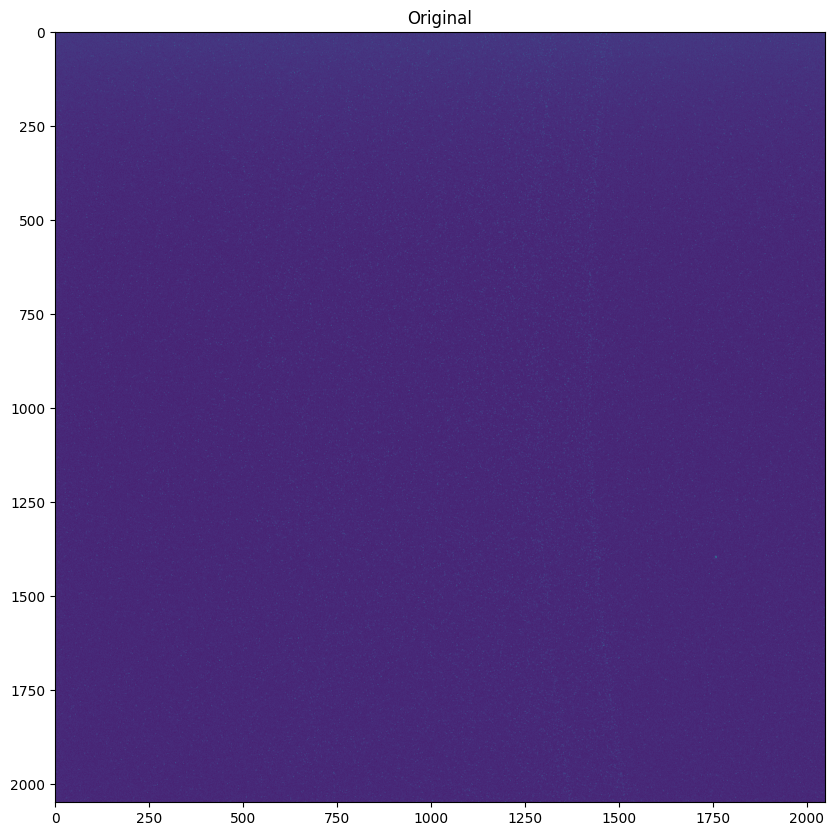

In [5]:
from file_utils import load_image

# Load an image
img = load_image("data/images/image8.npy")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title("Original")

Text(0.5, 1.0, 'Bias subtracted')

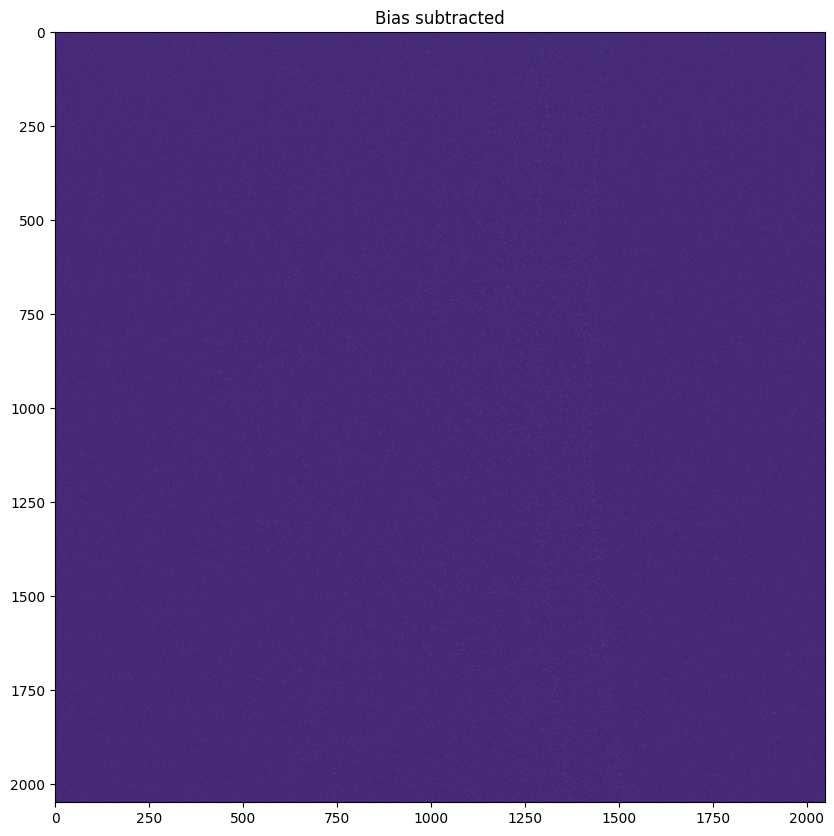

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(img-bias)
plt.title("Bias subtracted")

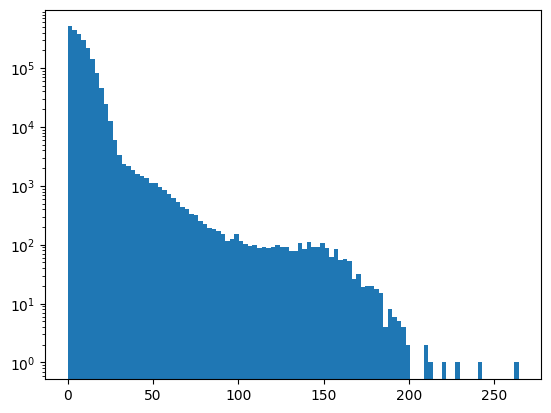

In [7]:
bin_centres, hist_data = make_histogram(img-bias, 100)

plt.bar(bin_centres, hist_data, width = bin_centres[1]-bin_centres[0])
plt.yscale("log")


# Detecting spectral lines

The spectral lines should have a greater abundance of photons from the emission lines compared to the rest of the image. We also know the energies of photons comprising these lines to a good degree of accuracy, since they are the Ge $L\alpha$ and $L\beta$ emission lines. Hence, by creating a histogram of the photons inside a line, we should be able to convert measured intensity values to photon energies.

## Shape of lines

We expect the lines to be arcs of a circle on the CCD. One way to automatically find these lines would be to detect heightened hit density in lineouts at different heights across the image, and fit a circle to them.

Hence, the first step is getting the equation of a circle that goes through three points. Code taken from [here](https://www.geeksforgeeks.org/equation-of-circle-when-three-points-on-the-circle-are-given/). If this code ends up being useful, remember to rewrite.

In [8]:
from math import sqrt
 
# Function to find the circle on 
# which the given three points lie 
def findCircle(x1, y1, x2, y2, x3, y3) :
    x12 = x1 - x2 
    x13 = x1 - x3 
 
    y12 = y1 - y2 
    y13 = y1 - y3 
 
    y31 = y3 - y1 
    y21 = y2 - y1 
 
    x31 = x3 - x1 
    x21 = x2 - x1 
 
    # x1^2 - x3^2 
    sx13 = pow(x1, 2) - pow(x3, 2) 
 
    # y1^2 - y3^2 
    sy13 = pow(y1, 2) - pow(y3, 2) 
 
    sx21 = pow(x2, 2) - pow(x1, 2) 
    sy21 = pow(y2, 2) - pow(y1, 2) 
 
    f = (((sx13) * (x12) + (sy13) *
          (x12) + (sx21) * (x13) +
          (sy21) * (x13)) // (2 *
          ((y31) * (x12) - (y21) * (x13))))
             
    g = (((sx13) * (y12) + (sy13) * (y12) +
          (sx21) * (y13) + (sy21) * (y13)) //
          (2 * ((x31) * (y12) - (x21) * (y13)))) 
 
    c = (-pow(x1, 2) - pow(y1, 2) -
         2 * g * x1 - 2 * f * y1) 
 
    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0 
    # where centre is (h = -g, k = -f) and 
    # radius r as r^2 = h^2 + k^2 - c 
    h = -g 
    k = -f 
    sqr_of_r = h * h + k * k - c 
 
    # r is the radius 
    r = round(sqrt(sqr_of_r), 5)
 
    return h, k, r


In [9]:
# Example, choosing points by hand

print(f"centre, radius: {findCircle(1420,1051,1446,236,1505,1934)}")
centre = findCircle(1420,1051,1446,236,1505,1934)[0:2]
radius = findCircle(1420,1051,1446,236,1505,1934)[2]

centre, radius: (8080, 856, 6662.85412)


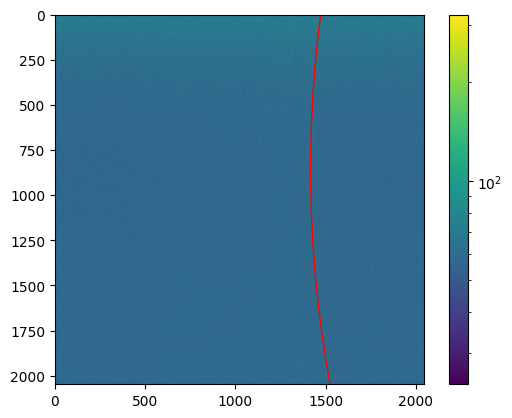

In [10]:
import matplotlib.patches as patches

circle = patches.Circle((8080,856), 6663, fill=False, color='red')
plt.imshow(img, norm=LogNorm())
plt.colorbar()
plt.gca().add_patch(circle)
plt.show()

## Finding the peaks

### Taking a lineout

The first task is to be able to take horizontal lineouts across different parts of the spectrum. We aim to see clear, distinct peaks at the spectral line locations. Since hits are so sparse relative to the size of the image, I found that the best way to do this is to define a height and averaging width for the lineout to get the clearest peaks.

This leaves 2 parametes, the line width and the x-direction averaging period which can be changed. I found that values of 500px and 35px worked fairly well, althgough this could still be optimised


In [11]:
#img=hot_pixels
def make_lineout(img, y, dy, xavg_period):
    """Return a lineout of the image at y +- dy, averaging over xavg_period pixels."""
    lineout = np.zeros(img.shape[1]-xavg_period)

    for x in range(img.shape[1]-xavg_period):
        lineout[x] = np.mean(img[y-dy:y+dy, x:x+xavg_period])
    
    return lineout

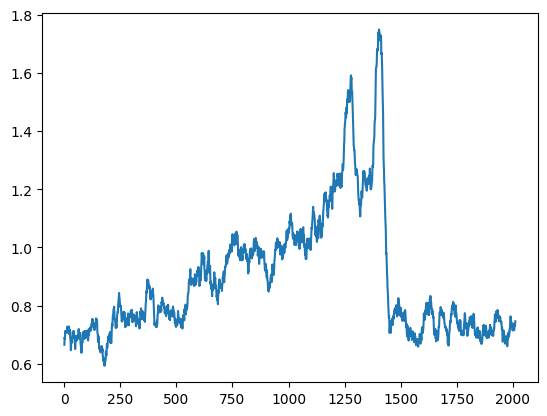

In [12]:
lineout = make_lineout(img-bias, img.shape[0]//2, 500, 35)
plt.plot(lineout)

### Peak finding
The 2 peaks are clear to the eye, so we now need an algorithm to find them. This is the one I came up with:


- Define a min peak separation
- Find all peaks that occur above $n\sigma$ of the signal mean (a "peak" is when array values go from increasing -> decreasing)
- Use a rolling window of the width of the min peak separation
    - Only allow one peak in the rolling window. If a second is found, delete whichever is smaller
- Scan over the whole image doing this
- Finally, only take the biggest 2 peaks, and these should be the spectral lines


In [13]:
## Algoritm code goes here


To improve this further, we could only consider lineout values that differ sufficiently from the lineout mean


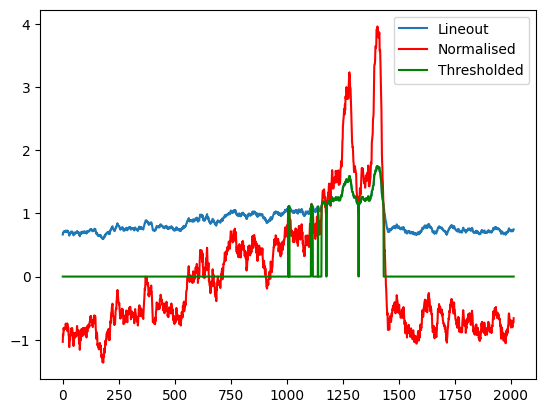

In [14]:
mean = lineout.mean()
std = lineout.std()

xvals = np.arange(len(lineout))
plt.plot(xvals, lineout, label="Lineout")
plt.plot(xvals, (lineout-mean)/std, color="red", label="Normalised")
plt.plot(xvals, [i if i > mean+std else 0 for i in lineout], color="green", label="Thresholded")
plt.legend()

## Looking at histogram for pixels in spectral line

We now want to compare the hisogram inside a spectral line to that for the rest of the image

In [34]:
def create_arc_mask(img, radius, center, width):
    """Create an arc mask for a given arc radius, center (in format (x,y)), and width."""
    center = center[::-1]
    x, y = np.indices((img.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = np.logical_and(r > radius - width/2, r < radius + width/2)
    return mask

### Manually selecting peak

Centre = (8080, 856)
Radius = 6663

In [35]:
# Getting all pixels that are in the peak
width = 10
centre = (8080,856)
radius = 6663

mask = create_arc_mask(img, radius, centre, width)

line_data = np.where(mask, img, 0).flatten()
line_data = line_data[line_data != 0]

Text(0.5, 1.0, 'Histogram along a peak')

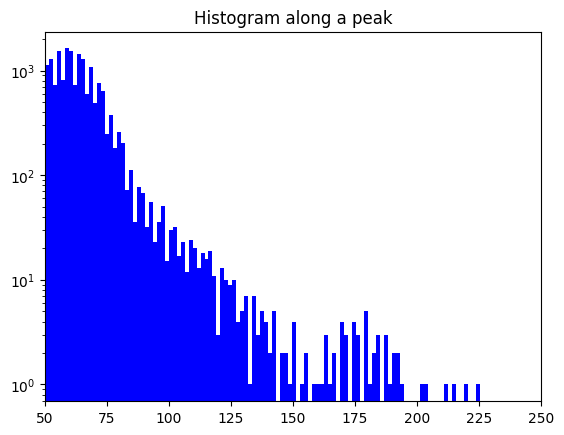

In [36]:
# make a histogram out of this
bin_centres, hist_data = make_histogram(line_data, 200)

plt.bar(bin_centres, hist_data, width=bin_centres[1]-bin_centres[0], color='blue')
plt.xlim(50,250)
plt.yscale("log")
plt.title("Histogram along a peak")

### Comparing to other histogram

C:\Users\jwbar\AppData\Local\Temp\ipykernel_19468\3688924711.py:10: RuntimeWarning: invalid value encountered in divide
  normalised = line_hist_data/img_hist_data


Text(0.5, 1.0, 'Histogram in a peak normalised to image histogram')

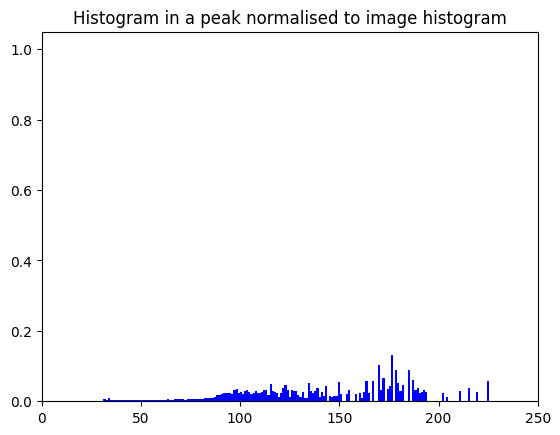

In [43]:
n_bins = 300

line_bin_centres, line_hist_data = make_histogram(line_data, n_bins)
img_bin_centres, img_hist_data = make_histogram(img, n_bins)

n_pixels_in_line = len(line_data)

difference = line_hist_data/n_pixels_in_line - img_hist_data/(img.shape[0]*img.shape[1])

normalised = line_hist_data/img_hist_data

plt.bar(img_bin_centres, normalised, width=img_bin_centres[1]-img_bin_centres[0], color='blue')
plt.xlim(0,250)
#plt.yscale("log")
plt.title("Histogram in a peak normalised to image histogram")


### Verification

This looks promising, since we a peak at around 175. Let's try taking a circle that's not on a spectral line, and seeing if we get the same thing. 

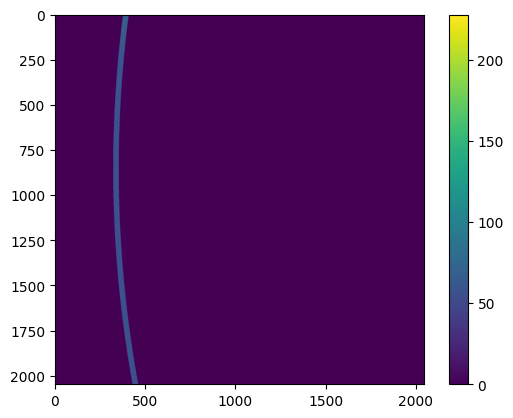

In [38]:
control_width = 30
control_centre = (7000,856) # centre moved significantly
control_radius = 6663

control_mask = create_arc_mask(img, control_radius, control_centre, control_width)

control_line_data = np.where(control_mask, img, 0).flatten()
control_line_data = control_line_data[control_line_data != 0]


# just to check that we're nowhere near the line this time
plt.imshow(np.where(control_mask, img, 0))
plt.colorbar()
plt.show()

C:\Users\jwbar\AppData\Local\Temp\ipykernel_19468\2034598684.py:10: RuntimeWarning: divide by zero encountered in divide
  control_normalised = control_line_hist_data/img_hist_data
C:\Users\jwbar\AppData\Local\Temp\ipykernel_19468\2034598684.py:10: RuntimeWarning: invalid value encountered in divide
  control_normalised = control_line_hist_data/img_hist_data


<BarContainer object of 300 artists>

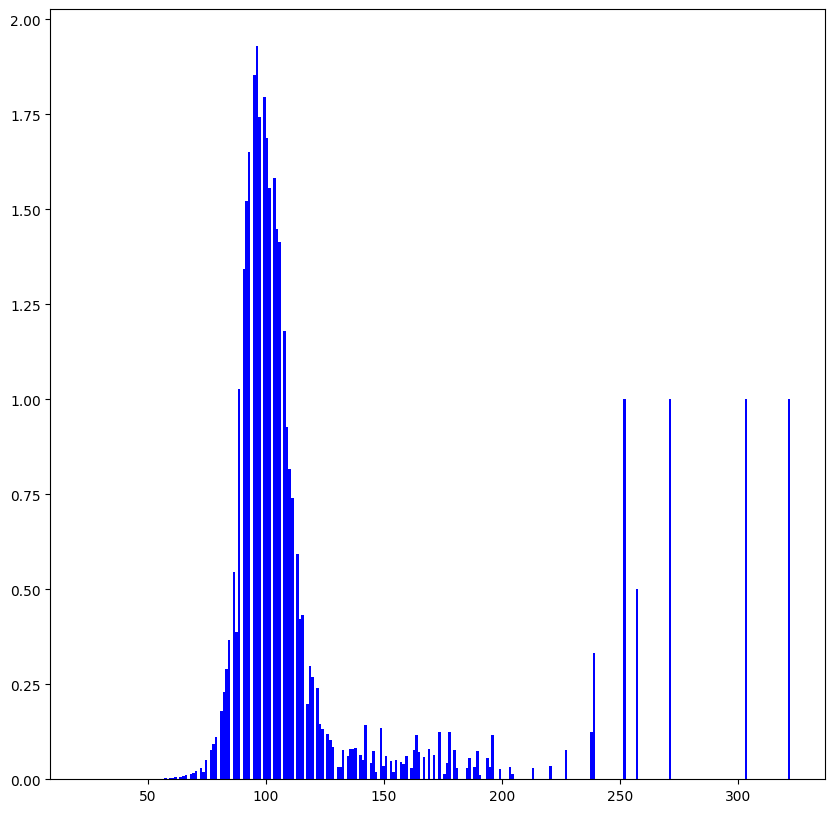

In [42]:
n_bins = 300

control_line_bin_centres, control_line_hist_data = make_histogram(control_line_data, n_bins)
img_bin_centres, img_hist_data = make_histogram(img, n_bins)

control_n_pixels_in_line = len(control_line_data)

control_difference = control_line_hist_data/control_n_pixels_in_line - img_hist_data/(img.shape[0]*img.shape[1])

control_normalised = control_line_hist_data/img_hist_data

plt.figure(figsize=(10,10))
plt.bar(img_bin_centres, control_normalised, width=img_bin_centres[1]-img_bin_centres[0], color='blue')


There seems to be a large peak around 100. Not sure yet why this is - perhaps because we are in a low signal region, the majority of pixels are noise, more so than the rest of the image

# Next week

- Repeat these tests with different noise removal techniques, and only considering hot pixels to hopefully get better data, since we are not really seeing much at the moment.
- Use these peaks to convert pixel intensity to photon energies.
- If this is working, implement peak detection algorithm to find the peaks automatically.
- Use this to produce spectra.

# Further things

- Remember to eventually use full hit extent to get the total intensity - this may need to be done to get viable results.
- Could we consider shape of spectral lines in photon energy space to guide how we fit the histograms? I assume some sort of Gaussian line broadening takes place.

# Questions
- Do we have any dark images? Would make noise removal much easier, since we could just subtract a dark image from each image.
- Does the current noise removal stuff I've been doing make sense? It all seems quite simplistic.
- Final spectrum - essentially just a histogram of the hits?
- Is the current progress + plan ambitious enough?
